# Import libraries

In [1]:
import numpy as np                 # Scientific Computation
import pandas as pd                # Loading and Manipulating Datasets
import matplotlib.pyplot as plt    # Plotting Graphs
import math
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import concatenate
from keras.layers import Reshape
from keras.layers.core import RepeatVector
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


# Import Train Data

In [2]:
dataset = pd.read_csv('PAICC_train.csv')
dataset_train = dataset.iloc[:,1:7].values

sc = StandardScaler()
data_train=[]
for i in range(5,3304+1):
    data_train.append(dataset_train[i-5:i,:])
# data_train = np.array(data_train)        

data_train_scaled = []
for w in data_train:
    norm_win = sc.fit_transform(w)
    data_train_scaled.append(norm_win)
data_train_scaled = np.array(data_train_scaled)
data_train_scaled.shape

(3300, 5, 6)

## Train data

In [3]:
x_train = data_train_scaled[0:3299,:,:]
y_train = data_train_scaled[1:3300,4,:]
y_train=np.expand_dims(y_train, axis=1)
print(x_train.shape)
print(y_train.shape)

(3299, 5, 6)
(3299, 1, 6)


## Test data

# Preprocessing

In [4]:
# norm_data = []
# for w in X_train:
#     norm_win = sc.fit_transform(w)
#     norm_data.append(norm_win)
# norm_data = np.array(norm_data)
# x_train=norm_data[:,0:5,:]
# y_train=norm_data[:,-1,:]
# y_train=np.expand_dims(y_train, axis=1)

# Model Parameters

In [5]:
feature_size=6
feature_size=6
step_time=5
gan_input_dim=(step_time,feature_size)

# Create GAN

### Optimizer

In [6]:
def get_optimizer():
    return Adam(lr = 0.01, beta_1 = 0.5) 

### Discriminator

In [7]:
def get_discriminator(optimizer,step_time,feature_size):
    discriminator = Sequential()
    discriminator.add(Dense(units = 72,input_dim=(step_time+1)*feature_size))
    discriminator.add(LeakyReLU(alpha = 0.2))
    discriminator.add(Dense(units = 100))
    discriminator.add(LeakyReLU(alpha = 0.2))
    discriminator.add(Dense(units = 10))
    discriminator.add(LeakyReLU(alpha = 0.2))
    discriminator.add(Dense(units = 1,activation = 'sigmoid'))
    discriminator.compile(loss ='binary_crossentropy', optimizer = optimizer)
    return discriminator

### Generator

In [8]:
def get_generator(optimizer,feature_size):
    generator = Sequential()
    generator.add(LSTM(units = 10, return_sequences = False, input_shape = (x_train.shape[1], feature_size)))
    generator.add(Dense(units = feature_size))
    generator.add(LeakyReLU(alpha = 0.2))
    generator.add(RepeatVector(1))
    generator.compile(loss ='mse', optimizer = optimizer)
    return generator

### GAN

In [9]:
def get_gan_network(discriminator, gan_input_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the generator or discriminator at a time
    discriminator.trainable = False
    
    gan_input = Input(shape=gan_input_dim)
    x = generator(gan_input)
    # Concatenate the output of the generator with real data
    val=concatenate(inputs=[gan_input,x],axis=1)
    R=Reshape((36,))(val)
    gan_output = discriminator(R)
    
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss ='binary_crossentropy', optimizer = optimizer)
    return gan

# Train GAN

In [10]:
def train(epochs,step_time,feature_size,gan_input_dim,batch_size=30):
    
    batch_count = x_train.shape[0] // batch_size
    
    adam = get_optimizer()
    generator = get_generator(adam,feature_size)
    discriminator = get_discriminator(adam,step_time,feature_size)
    gan = get_gan_network(discriminator, gan_input_dim, generator, adam)
    
    for e in range(1, epochs+1):
        D_loss=[]
        G_loss=[]
        # Train the Network in Batchs
        for i in range (0,batch_count):
            X_tr_batch=x_train[i*batch_size:(i+1)*batch_size,:,:]
            Y_tr_batch=y_train[i*batch_size:(i+1)*batch_size,:,:]
            pred = generator.predict(X_tr_batch)

            X_real = np.concatenate((X_tr_batch, Y_tr_batch),axis=1)
            X_real = np.reshape(X_real,(-1,36,))
            X_fake = np.concatenate((X_tr_batch, pred),axis=1)
            X_fake = np.reshape(X_fake,(-1,36,))

            fake = np.zeros((batch_size,1))
            real = np.ones((batch_size,1))
            
            # Train discriminator
            discriminator.trainable = True
    
            d_loss_real=discriminator.train_on_batch(X_real, real)

            d_loss_fake=discriminator.train_on_batch(X_fake, fake)
            d_loss=np.add(d_loss_real,d_loss_fake)
            D_loss.append(d_loss)

    
            # Train generator
            discriminator.trainable = False
            y_gen = np.ones((batch_size,1))
            g_loss=gan.train_on_batch(X_tr_batch, y_gen)
            G_loss.append(g_loss)
            # Print the Results
            print ("epoch : %d , batch : %d , D loss : %f , G loss : %f" % (e,i, d_loss,g_loss))
    return gan,generator,discriminator,D_loss,G_loss

In [11]:
# Train the GAN Network
if __name__ == '__main__':
    gan1,generator1,discriminator1,D_loss,G_loss=train(5,step_time,feature_size,gan_input_dim,30)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
epoch : 1 , batch : 0 , D loss : 2.537817 , G loss : 0.454886
epoch : 1 , batch : 1 , D loss : 1.687985 , G loss : 0.604857
epoch : 1 , batch : 2 , D loss : 1.362172 , G loss : 0.654552
epoch : 1 , batch : 3 , D loss : 1.295413 , G loss : 0.703019
epoch : 1 , batch : 4 , D loss : 1.254460 , G loss : 0.705087
epoch : 1 , batch : 5 , D loss : 1.155285 , G loss : 0.753001
epoch : 1 , batch : 6 , D loss : 1.074201 , G loss : 0.775038
epoch : 1 , batch : 7 , D loss : 1.222386 , G loss : 0.793085
epoch : 1 , batch : 8 , D loss : 1.192769 , G loss : 0.840440
epoch : 1 , batch : 9 , D loss : 1.046424 , G loss : 0.912389
epoch : 1 , batch : 10 , D loss : 0.849299 , G loss : 1.047421
epoch : 1 , batch : 11 , D loss : 1.197471 , G loss : 0.964237
epoch : 1 , batch : 12 , D loss : 1.705507 , G loss : 1.321948
epoch : 1 , batch : 13 , D loss : 1.139211 , G loss : 1.064897
epoch : 

epoch : 2 , batch : 22 , D loss : 1.213719 , G loss : 1.334873
epoch : 2 , batch : 23 , D loss : 1.037866 , G loss : 1.392112
epoch : 2 , batch : 24 , D loss : 1.345093 , G loss : 1.193666
epoch : 2 , batch : 25 , D loss : 1.181651 , G loss : 1.232688
epoch : 2 , batch : 26 , D loss : 1.156292 , G loss : 1.149086
epoch : 2 , batch : 27 , D loss : 0.920258 , G loss : 1.436649
epoch : 2 , batch : 28 , D loss : 0.795596 , G loss : 1.552139
epoch : 2 , batch : 29 , D loss : 0.689537 , G loss : 1.689967
epoch : 2 , batch : 30 , D loss : 1.133419 , G loss : 1.468931
epoch : 2 , batch : 31 , D loss : 0.857269 , G loss : 1.428049
epoch : 2 , batch : 32 , D loss : 0.782816 , G loss : 1.632280
epoch : 2 , batch : 33 , D loss : 0.859729 , G loss : 1.663210
epoch : 2 , batch : 34 , D loss : 0.816291 , G loss : 1.544116
epoch : 2 , batch : 35 , D loss : 0.758728 , G loss : 1.498205
epoch : 2 , batch : 36 , D loss : 0.798525 , G loss : 1.462745
epoch : 2 , batch : 37 , D loss : 1.150663 , G loss : 1

epoch : 3 , batch : 53 , D loss : 0.924511 , G loss : 1.217865
epoch : 3 , batch : 54 , D loss : 0.818674 , G loss : 1.300122
epoch : 3 , batch : 55 , D loss : 1.192407 , G loss : 1.173280
epoch : 3 , batch : 56 , D loss : 1.094616 , G loss : 1.183600
epoch : 3 , batch : 57 , D loss : 0.893631 , G loss : 1.262520
epoch : 3 , batch : 58 , D loss : 0.869226 , G loss : 1.514092
epoch : 3 , batch : 59 , D loss : 1.015672 , G loss : 1.421012
epoch : 3 , batch : 60 , D loss : 1.144308 , G loss : 1.202404
epoch : 3 , batch : 61 , D loss : 1.175920 , G loss : 1.230274
epoch : 3 , batch : 62 , D loss : 1.498478 , G loss : 1.191699
epoch : 3 , batch : 63 , D loss : 0.985598 , G loss : 1.206425
epoch : 3 , batch : 64 , D loss : 1.132123 , G loss : 1.128354
epoch : 3 , batch : 65 , D loss : 1.213471 , G loss : 1.254501
epoch : 3 , batch : 66 , D loss : 0.952213 , G loss : 1.260359
epoch : 3 , batch : 67 , D loss : 1.019226 , G loss : 1.296034
epoch : 3 , batch : 68 , D loss : 1.097892 , G loss : 1

epoch : 4 , batch : 85 , D loss : 1.361619 , G loss : 0.989526
epoch : 4 , batch : 86 , D loss : 1.465289 , G loss : 0.887045
epoch : 4 , batch : 87 , D loss : 1.178155 , G loss : 1.080282
epoch : 4 , batch : 88 , D loss : 1.506377 , G loss : 0.893358
epoch : 4 , batch : 89 , D loss : 1.283617 , G loss : 0.987353
epoch : 4 , batch : 90 , D loss : 1.436107 , G loss : 0.951819
epoch : 4 , batch : 91 , D loss : 1.190398 , G loss : 0.995531
epoch : 4 , batch : 92 , D loss : 1.330615 , G loss : 0.897206
epoch : 4 , batch : 93 , D loss : 1.351627 , G loss : 0.880462
epoch : 4 , batch : 94 , D loss : 1.105958 , G loss : 0.994164
epoch : 4 , batch : 95 , D loss : 1.219142 , G loss : 0.959220
epoch : 4 , batch : 96 , D loss : 1.261962 , G loss : 0.972681
epoch : 4 , batch : 97 , D loss : 1.257474 , G loss : 0.994796
epoch : 4 , batch : 98 , D loss : 1.196605 , G loss : 1.010761
epoch : 4 , batch : 99 , D loss : 1.248105 , G loss : 0.989862
epoch : 4 , batch : 100 , D loss : 1.394373 , G loss : 

## Plot D_loss

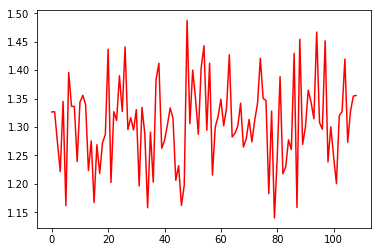

In [12]:
D_loss=np.array(D_loss)
plt.plot(D_loss, color = 'red')

## Plot G_loss

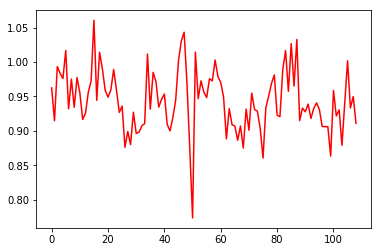

In [13]:
G_loss=np.array(G_loss)
plt.plot(G_loss, color = 'red')

# Import Test Data

In [14]:
dataset = pd.read_csv('PAICC_test.csv')
dataset_test = dataset.iloc[:,1:7].values

data_test=[]
for i in range(5,368+1):
    data_test.append(dataset_test[i-5:i,:])
# data_train = np.array(data_train)        

data_test_scaled = []
for w in data_test:
    norm_win = sc.fit_transform(w)
    data_test_scaled.append(norm_win)
data_test_scaled = np.array(data_test_scaled)
data_test_scaled.shape

(364, 5, 6)

In [15]:
x_test = data_test_scaled[0:363,:,:]
y_test = data_test_scaled[1:364,4,:]
y_test=np.expand_dims(y_test, axis=1)
print(x_test.shape)
print(y_test.shape)

(363, 5, 6)
(363, 1, 6)


# Testing our GAN

In [16]:
predicted=generator1.predict(x_test)

# Inverse Transform the Results

In [17]:
predicted.shape

(363, 1, 6)

In [18]:
X_inverse = []
inverse_y_test=[]
inverse_predicted=[]
i=0
for w in data_test:
    if i>362:
        break
    sc.fit(w)
    inverse_y_test.append(sc.inverse_transform(y_test[i,:,:]))
    inverse_predicted.append(sc.inverse_transform(predicted[i,:,:]))
    i+=1
inverse_y_test=np.array(inverse_y_test)
inverse_predicted=np.array(inverse_predicted)

# Plot the Results 

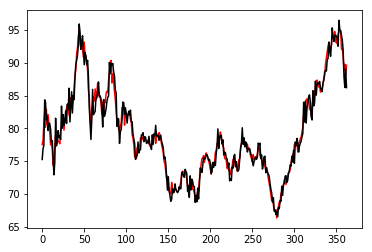

In [19]:
plt.plot(inverse_y_test[:,0,3],color = 'red')
plt.plot(inverse_predicted[:,0,3],color = 'black')

# Indicators

### MAE

In [20]:
N = 362
a = abs(inverse_y_test[:,0,3]-inverse_predicted[:,0,3]) #close s&p500
MAE = a[0]
for i in range(1,362):
    MAE = a[i] + MAE
MAE = MAE/N
MAE  

0.9634374578882289

### RMSE

In [21]:
RMSE = a[0]**2
for i in range(1,362):
    RMSE = a[i]**2 + RMSE
RMSE = RMSE/N
math.sqrt(RMSE)

1.250965130997289

### MAPE

In [22]:
MAPE = a[0]/inverse_y_test[:,0,3][0]
for i in range(0,362):
    MAPE = MAPE + a[i]/inverse_y_test[:,0,3][i]
MAPE = MAPE/N 
MAPE

0.012116216420593138

### AR

In [23]:
for i in range(1,362):
    if inverse_predicted[:,0,3][i+1] > inverse_predicted[:,0,3][i]:
        AR = inverse_y_test[:,0,3][1]-inverse_y_test[:,0,3][0]
        AR = AR + (inverse_y_test[:,0,3][i+1]-inverse_y_test[:,0,3][i])
        AR = AR/(N-1)
AR

-0.0024343886513238126